# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.


## Задачи
1. Рассчитать параметры теста: необходимый размер выборки и длительность теста.
2. Оценить изменения ключевой метрики (доля сессий с четырьмя и более просмотренными страницами), прокси-метрик (количество всех сессий в день)
3. Оценить корректность проведения теста и проанализировать результаты эксперимента, можно ли произошедшие изменения считать значимыми.

### 1. Работа с историческими данными (EDA)

In [2]:
!pip install matplotlib-venn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles

In [12]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [13]:
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными

In [14]:
sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending=False)

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

In [15]:
sessions_history[sessions_history['user_id'] == '10E0DEFC1ABDBBE0']

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций

In [16]:
unique_ids = sessions_history.groupby('session_date')['user_id'].nunique().reset_index()
unique_ids = unique_ids.rename(columns = {'user_id': 'unique_users_qty'})
unique_ids.head()

,session_date,unique_users_qty
0,2025-08-11,3919
1,2025-08-12,6056
2,2025-08-13,8489
3,2025-08-14,10321
4,2025-08-15,14065


In [17]:
unique_registered = sessions_history[sessions_history['registration_flag'] == 1].groupby('session_date')['user_id'].nunique().reset_index()
unique_registered = unique_registered.rename(columns = {'user_id': 'unique_registered_qty'})
unique_registered.head()

,session_date,unique_registered_qty
0,2025-08-11,169
1,2025-08-12,336
2,2025-08-13,464
3,2025-08-14,625
4,2025-08-15,840


In [18]:
users_per_dates = unique_ids.merge(unique_registered, on='session_date')
users_per_dates['registered_users_share'] = users_per_dates['unique_registered_qty']/users_per_dates['unique_users_qty']
users_per_dates.head()

,session_date,unique_users_qty,unique_registered_qty,registered_users_share
0,2025-08-11,3919,169,0.043123
1,2025-08-12,6056,336,0.055482
2,2025-08-13,8489,464,0.054659
3,2025-08-14,10321,625,0.060556
4,2025-08-15,14065,840,0.059723


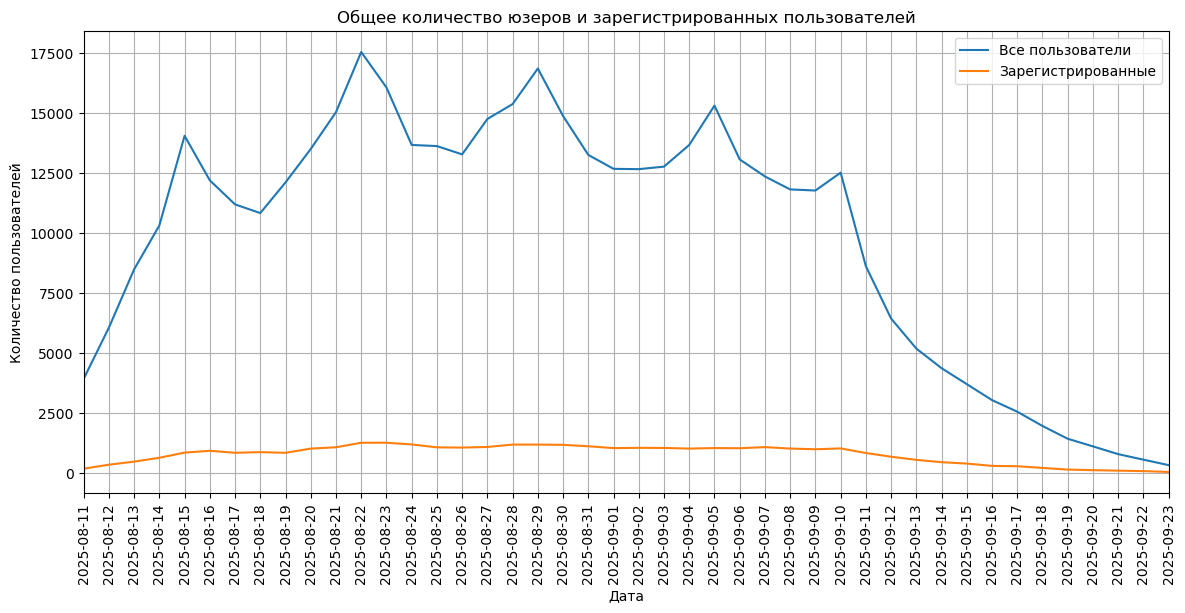

In [19]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=users_per_dates, x='session_date', y='unique_users_qty', label='Все пользователи')
sns.lineplot(data=users_per_dates, x='session_date', y='unique_registered_qty', label='Зарегистрированные')
plt.title('Общее количество юзеров и зарегистрированных пользователей')
plt.xlabel('Дата')
plt.xlim([users_per_dates['session_date'].min(), users_per_dates['session_date'].max()])
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.show()

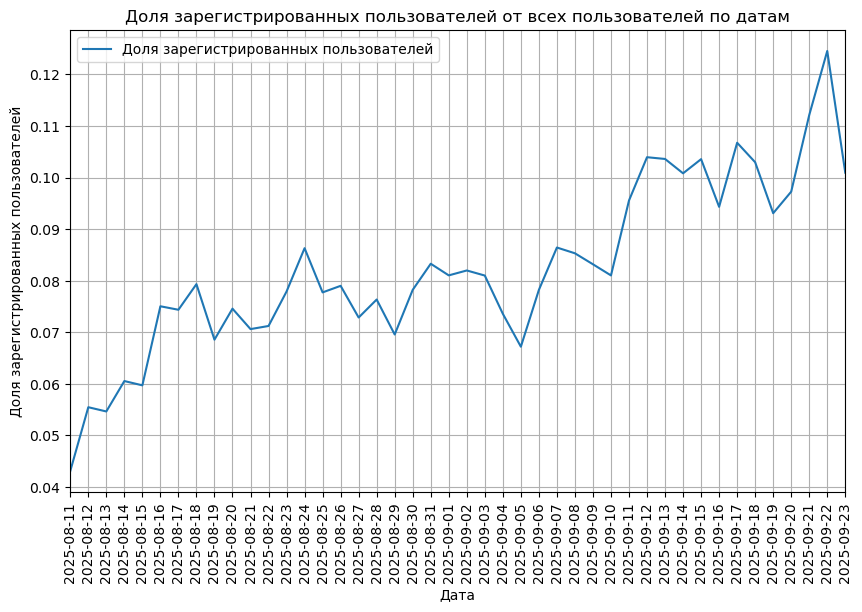

In [20]:
plt.figure(figsize = (10, 6))
sns.lineplot(data = users_per_dates, x = 'session_date', y = 'registered_users_share', label = 'Доля зарегистрированных пользователей')
plt.title('Доля зарегистрированных пользователей от всех пользователей по датам')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.xlim([users_per_dates['session_date'].min(), users_per_dates['session_date'].max()])
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.show()

#### 1.4. Анализ числа просмотренных страниц

In [21]:
sessions_count = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
sessions_count = sessions_count.rename(columns = {'session_id': 'num_sessions'})
sessions_count

,page_counter,num_sessions
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


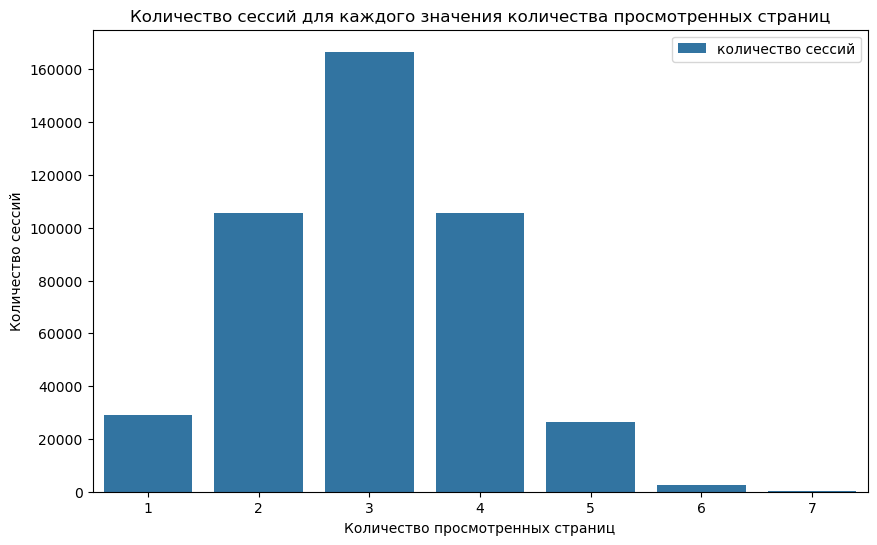

In [22]:
plt.figure(figsize = (10, 6))
sns.barplot(data = sessions_count, x = 'page_counter', y = 'num_sessions', label = 'количество сессий')
plt.title('Количество сессий для каждого значения количества просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.show()

По построенному графику мы видим:
1. Количество сессий с четырьмя просмотренными страницами аналогично количеству с двумя просмотренными страницами.
2. Чаще всего пользователи открывают за одну сессию три страницы. 
3. Сессии с семью открытыми страницами можно считать аномальными, так как менее ста человек просматривают их. 

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [13]:
sessions_history['good_session'] = sessions_history['page_counter'].apply(lambda x: 1 if x>= 4 else 0)
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [14]:
good_sessions = sessions_history.groupby('session_date')['good_session'].agg({'count', 'sum'}).reset_index()
good_sessions = good_sessions.rename(columns = {'sum': 'good_sessions',
                               'count': 'all_sessions_qty'})
good_sessions['good_sessions_share'] = good_sessions['good_sessions']/good_sessions['all_sessions_qty']
good_sessions.head()

,session_date,good_sessions,all_sessions_qty,good_sessions_share
0,2025-08-11,1226,3919,0.312835
1,2025-08-12,1829,6056,0.302015
2,2025-08-13,2604,8489,0.306750
3,2025-08-14,3262,10321,0.316055
4,2025-08-15,4289,14065,0.304941


In [15]:
mean = round(good_sessions['good_sessions_share'].mean(), 2)
print(f"Среднее значение доли успешных сессий ко всем сессиям по дням за весь период наблюдения составляет {mean}")

Среднее значение доли успешных сессий ко всем сессиям по дням за весь период наблюдения составляет 0.31


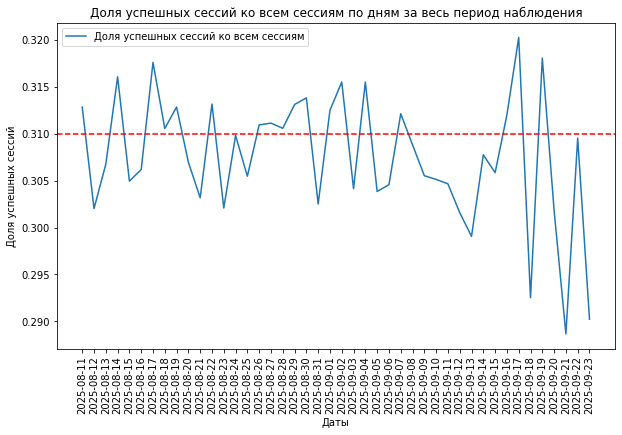

In [16]:
plt.figure(figsize = (10, 6))
sns.lineplot(data = good_sessions, x = 'session_date', y='good_sessions_share', label='Доля успешных сессий ко всем сессиям')
plt.axhline(mean, color='red', linestyle='--', label=f'Среднее значение ({mean})')
plt.title('Доля успешных сессий ко всем сессиям по дням за весь период наблюдения')
plt.xlabel('Даты')
plt.ylabel('Доля успешных сессий')
plt.xticks(rotation=90)
plt.show()

Промежуточные выводы:
1. С 10 сентября 2025 года наблюдается устойчивое нижение количества пользователей приложения: падение настолько резкое, что к концу рассматриваемого исторического периода количество всех пользователей сравнялось с количеством зарегистрированных пользователей. Возможно, стоит дополнительно посмотреть на изменения в поведении пользователей: что случилось в приложении? Были ли зафиксированы жалобы пользователей? При этом с этого же дня растет доля зарегистрированных пользователей, может быть, была проведена какакя-то акция для новых клиентов? 
2. Ключевая метрика эксперимета = количество успешных сессий, где более 4 страниц были открыты. Чаще всего пользователи открывают три страницы, на втором месте - сессий с двумя и четырьмя просмотрами. 
3. Среднее значение доли успешных сессий примерно 0.31, в последние дни периода доля успешных сессий ниже среднего. Но на фоне общего уменьшения пользователей приложения это явление объяснимо.  

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
Параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. 

In [26]:
from statsmodels.stats.power import NormalIndPower

alpha = 0.05 
beta = 0.2  
power = 0.8  
mde = 0.03 

power_analysis = NormalIndPower()


sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


При анализе доли успешных сессий (4 просмотренных страниц и более) нам потребуется проанализировать поведение 34882 пользователей.

#### 2.1. Расчёт длительности A/B-теста

In [29]:
from math import ceil

avg_daily_users = ceil(users_per_dates['unique_users_qty'].mean())
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дня")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составит 4 дня


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [28]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
size = sessions_test_part.groupby('test_group')['user_id'].nunique().reset_index()
size

,test_group,user_id
0,A,1477
1,B,1466


In [20]:
a = 1477
b = 1466
p = 100*(a-b)/a
print(f"Разница в количестве пользователей между группами A и B составляет {round(p, 2)}%")

Разница в количестве пользователей между группами A и B составляет 0.74%


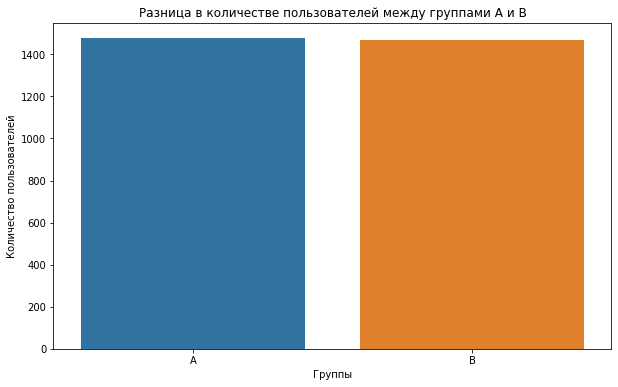

In [21]:
plt.figure(figsize = (10, 6))
sns.barplot(data = size, x = 'test_group', y = 'user_id', label = 'Разница в количестве пользователей')
plt.title('Разница в количестве пользователей между группами A и B')
plt.xlabel('Группы')
plt.ylabel('Количество пользователей')
plt.show()

#### 3.2. Проверка пересечений пользователей

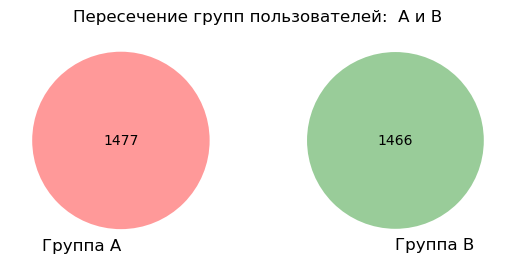

In [30]:
A = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'])
B = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])
venn2([A, B], set_labels=('Группа А', 'Группа B'))
plt.title("Пересечение групп пользователей:  A и B")
plt.show()

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [23]:
devices_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique().sort_values().reset_index()
devices_a['total'] = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
devices_a['share'] = round(devices_a['user_id']/devices_a['total'], 2)
devices_a

,device,user_id,total,share
0,Mac,156,1477,0.11
1,iPhone,296,1477,0.20
2,PC,369,1477,0.25
3,Android,656,1477,0.44


In [24]:
devices_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique().sort_values().reset_index()
devices_b['total'] = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()
devices_b['share'] = round(devices_b['user_id']/devices_b['total'], 2)
devices_b

,device,user_id,total,share
0,Mac,148,1466,0.10
1,iPhone,269,1466,0.18
2,PC,381,1466,0.26
3,Android,668,1466,0.46


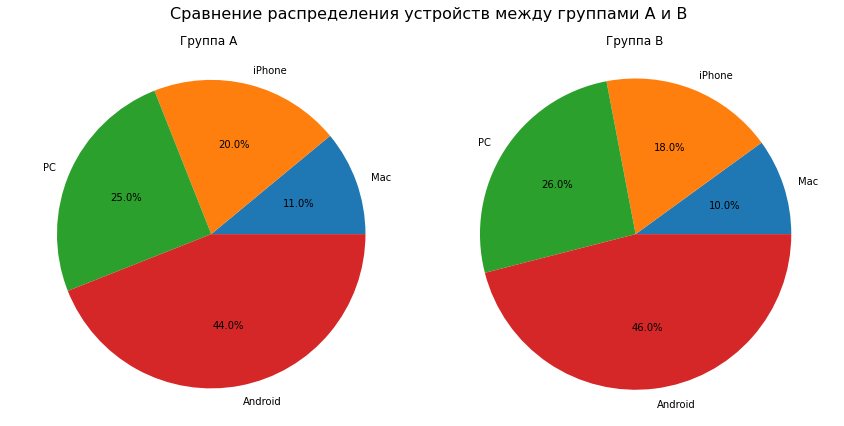

In [25]:
vals_a = devices_a['share']
labels_a = devices_a['device']

vals_b = devices_b['share']
labels_b = devices_b['device']

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].pie(vals_a, labels=labels_a, autopct='%1.1f%%')
axes[0].set_title('Группа A')
axes[0].axis('equal')

# Вторая диаграмма (группа B)
axes[1].pie(vals_b, labels=labels_b, autopct='%1.1f%%')
axes[1].set_title('Группа B')
axes[1].axis('equal')

plt.suptitle('Сравнение распределения устройств между группами A и B', fontsize=16)
plt.tight_layout()
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам

In [31]:
regions_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique().reset_index()
regions_a['total'] = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
regions_a['share'] = round(regions_a['user_id']/regions_a['total'], 2)
regions_a

,region,user_id,total,share
0,CIS,644,1477,0.44
1,EU,224,1477,0.15
2,MENA,609,1477,0.41


In [32]:
regions_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique().reset_index()
regions_b['total'] = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()
regions_b['share'] = round(regions_b['user_id']/regions_b['total'], 2)
regions_b

,region,user_id,total,share
0,CIS,645,1466,0.44
1,EU,217,1466,0.15
2,MENA,604,1466,0.41


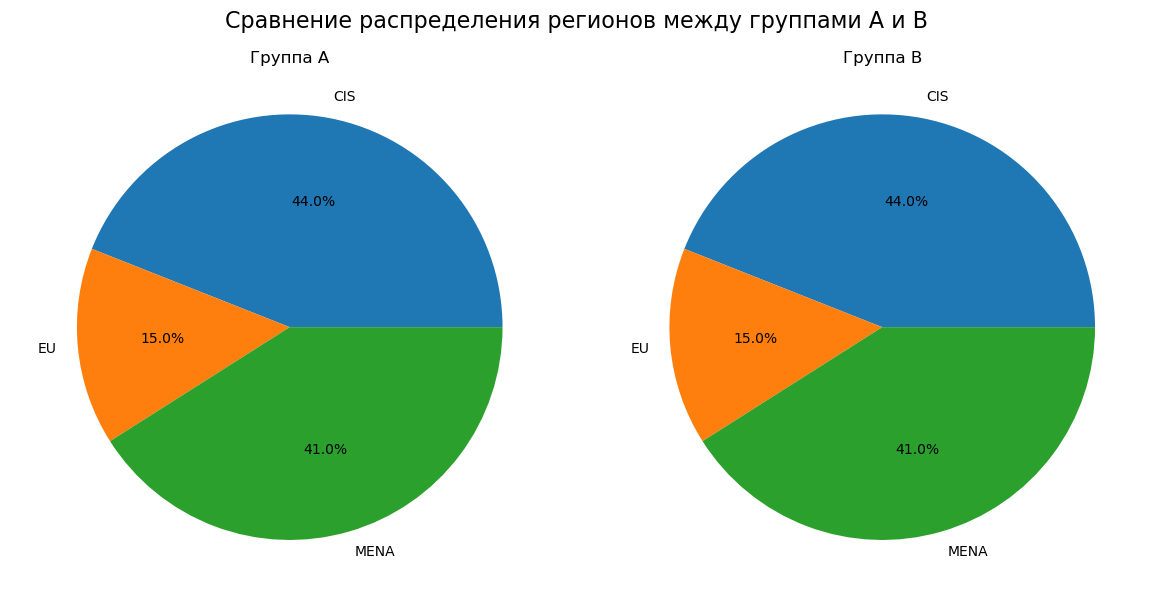

In [33]:
vals_A = regions_a['share']
labels_A = regions_a['region']

vals_B = regions_b['share']
labels_B = regions_b['region']

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].pie(vals_A, labels=labels_A, autopct='%1.1f%%')
axes[0].set_title('Группа A')
axes[0].axis('equal')

# Вторая диаграмма (группа B)
axes[1].pie(vals_B, labels=labels_B, autopct='%1.1f%%')
axes[1].set_title('Группа B')
axes[1].axis('equal')

plt.suptitle('Сравнение распределения регионов между группами A и B', fontsize=16)
plt.tight_layout()
plt.show()

#### 3.5. Вывод после проверки A/B-теста

Выводы:
1. Было обнаружено небольшое различие между группами, в А - 1477, в B - 1466, но в процентном отношении разница составляет менее 1, поэтому этой разницей можно пренебречь.
2. Выборки пользователей не пересекаются. 
3. Распределение тестовых групп в разрезе устройств равномерно, разница между ними не превышает 2%.
4. По регионам также соблюдается принцип равномерного распределения, расхождений нет. 

<div class="alert alert-block alert-info">
Поправила.
</div>

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [34]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x>= 4 else 0)
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Нулевая гипотеза: различий в количестве сессий по дням между  группами нет

Альтернативная гипотеза: между группами количество сессий не равное

In [35]:
sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique()

session_date  test_group
2025-10-14    A             1502
              B             1628
2025-10-15    A             2235
              B             2283
2025-10-16    A             3280
              B             3241
2025-10-17    A             4089
              B             4054
2025-10-18    A             5013
              B             5059
2025-10-19    A             6535
              B             6779
2025-10-20    A             5837
              B             6089
2025-10-21    A             3927
              B             3981
2025-10-22    A             3083
              B             3111
2025-10-23    A             2470
              B             2548
2025-10-24    A             2090
              B             2068
2025-10-25    A             1897
              B             1814
2025-10-26    A             1669
              B             1692
2025-10-27    A             1454
              B             1517
2025-10-28    A             1279
              B   

Поскольку между группами есть незначительное различие в разрезе распределения по устройствам, я решила провести тест Уэлча. 

In [36]:
from scipy import stats as st

a_group = sessions_test[sessions_test['test_group'] == 'A'].groupby('session_date')['session_id'].nunique()
b_group = sessions_test[sessions_test['test_group'] == 'B'].groupby('session_date')['session_id'].nunique()

results = st.ttest_ind(
    a_group,
    b_group,
    equal_var=False,
    alternative='two-sided') 
p_value = results.pvalue
p_value


0.9382195854082714

Полученное значение p_value = 0.9382195854082714. Критический уровень alpha = 0.05.

p_value значительно больше alpha, значит, нулевая гипотеза верна: разницы между двумя тестовыми группами практически нет. 

#### 4.3. Сравнение доли успешных сессий

In [37]:
good = sessions_test[sessions_test['good_session'] == 1].groupby('test_group')['good_session'].sum().reset_index()
test = sessions_test.groupby('test_group')['session_id'].nunique().reset_index()
total = good.merge(test, on = 'test_group')
total['perc_of_success'] = round(total['good_session']/total['session_id']*100, 2)
total = total.rename(columns = {'good_session': 'good_session_qty',
                                         'session_id': 'all_sessions_qty'})
total

,test_group,good_session_qty,all_sessions_qty,perc_of_success
0,A,15248,49551,30.77
1,B,16059,50454,31.83


In [38]:
a = total[total['test_group'] == 'A']['perc_of_success'].iloc[0]
b = total[total['test_group'] == 'B']['perc_of_success'].iloc[0]
difference = b-a
print(f"В процентном отношении разница в количестве успешных сессий между двумя группами составляет приблизительно {round(difference, 1)}%")

В процентном отношении разница в количестве успешных сессий между двумя группами составляет приблизительно 1.1%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

Нулевая гипотеза: изменений нет

Альтернативная: В группе В доля успешных сессий больше

Поскольку в контрольных группах я буду сравнивать доли успешных сессий, я выбрала z-тест пропорций.

In [39]:
from statsmodels.stats.proportion import proportions_ztest

n_a, n_b = 49551, 50454 
m_a, m_b = 15248, 16059 

alpha = 0.05 

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' 
)
p_value_ztest


if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.00015747399880361237 < 0.05
Нулевая гипотеза не находит подтверждения!


#### 4.5. Вывод по результатам A/B-эксперимента


1. 2025-10-14 начался А/В эксперимент, который длился 20 дней по 2025-11-02. В ходе эксперимента пользователи приложения были разделены на 2 практически равные группы по 1477 и 1466 человек соответственно. Группы не пересекались, распределение по используемым устройствам внутри каждой группы почти одинаковое, распределение по регионам идентичное в обеих группах. 
2. Новый алгоритм положительно повлиял на ключевую метрику: доля успешных сессий (более 4 просмотренных страниц за одно посещение) в контрольной группе В больше приблизительно на 1.1%, чем в группе, которая не видела нового алгоритма. Кажется, что это изменение небольшое, но при оценке этого изменения статистическим тестом (Z-тест) выяснилось, что это изменение значимо. 
3. Полученный pvalue=0.0001574739988036123, что меньше установленного уровня значимости (0.05). 
4. Нулевая гипотеза не находит подтверждения, можно утверждать, что новый алгоритм, который видела только группа В, положительно влияет на рост ключевой метрики. Можно рекомендовать введение нового алгоритма для всей целевой аудитории. 